# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *Your group letter.*

**Names:**

* *Name 1*
* *Name 2*
* *Name 3*

---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [2]:
import epidemics_helper
import os
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [3]:
with open(os.path.join('../data/nyc_augmented_network.json')) as file:
    data = json.load(file)
G = nx.readwrite.json_graph.node_link_graph(data)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 26481
Number of edges: 43437


In [52]:
sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1, verbose=False)

In [53]:
sir.launch_epidemic(source=23654, max_time=100.0)

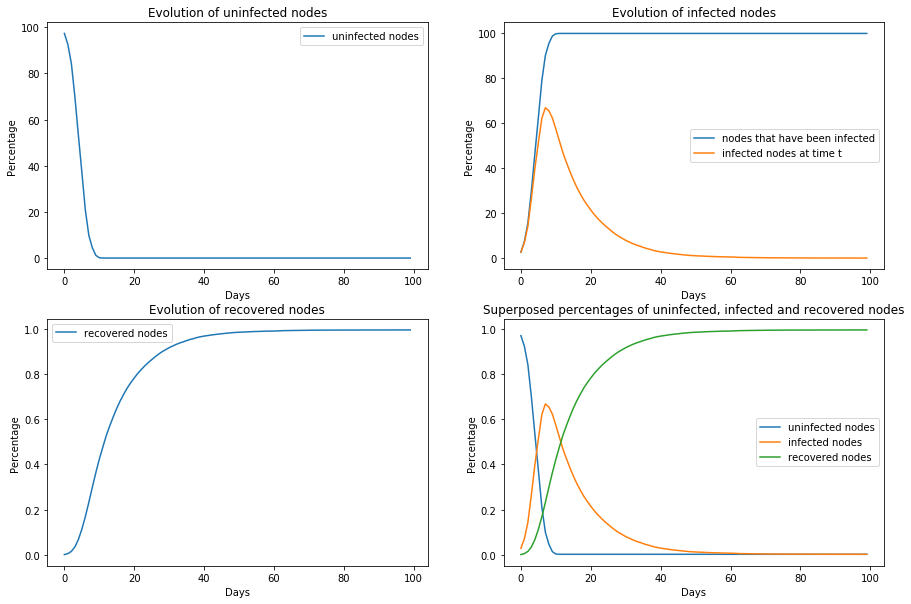

In [54]:
def status_percentages(sir):
    r = sir.rec_time.astype(int)
    r_c = np.cumsum(np.bincount(r[r > 0], minlength=100))
    i = sir.inf_time.astype(int)
    i_c = np.cumsum(np.bincount(i[i >= 0], minlength=100))
    h_c = np.zeros(100) + sir.n_nodes - i_c
    return h_c, i_c, r_c

h_c, i_c, r_c = status_percentages(sir)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.title('Evolution of uninfected nodes')
plt.plot(h_c / sir.n_nodes * 100, label='uninfected nodes')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.subplot(2,2,2)
plt.title('Evolution of infected nodes')
plt.plot(i_c / sir.n_nodes * 100, label='nodes that have been infected')
plt.plot((i_c - r_c) / sir.n_nodes * 100, label='infected nodes at time t')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.subplot(2,2,3)
plt.title('Evolution of recovered nodes')
plt.plot(r_c / sir.n_nodes, label='recovered nodes')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()
plt.subplot(2,2,4)
plt.title('Superposed percentages of uninfected, infected and recovered nodes')
plt.plot(h_c / sir.n_nodes, label='uninfected nodes')
plt.plot((i_c - r_c) / sir.n_nodes, label='infected nodes')
plt.plot(r_c / sir.n_nodes, label='recovered nodes')
plt.xlabel('Days')
plt.ylabel('Percentage')
plt.legend()

In [7]:
print('Time until 60% of population infected:', len(i_c[i_c < sir.n_nodes*.6]), 'days')
print('Time until 60% of population dead:', len(r_c[r_c < sir.n_nodes*.6]), 'days')

Time until 60% of population infected: 6 days
Time until 60% of population dead: 14 days


In [36]:
def visualize_epidemics(sir, src, days, order):
    sir.launch_epidemic(source=src, max_time=days)
    colors = ['green', 'red', 'black']
    classes = ['healthy', 'infected', 'dead']
    xcoord = [[],[],[]]
    ycoord = [[],[],[]]
    for i in range(G.number_of_nodes()):
        x, y = (G.node[i])['coordinates']
        xcoord[sir.status[i]] = np.append(xcoord[sir.status[i]], x / 1e6)
        ycoord[sir.status[i]] = np.append(ycoord[sir.status[i]], y / 1e6)
    plt.scatter(xcoord[order[0]], ycoord[order[0]], c=colors[order[0]], label=classes[order[0]], s=2)
    plt.scatter(xcoord[order[1]], ycoord[order[1]], c=colors[order[1]], label=classes[order[1]], s=2)
    plt.scatter(xcoord[order[2]], ycoord[order[2]], c=colors[order[2]], label=classes[order[2]], s=2)

    plt.title('Epidemic after %d days' % days)
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.legend()

Epidemic stopped after 1.01 days | 1.01 days elapsed | 96.9% susceptible, 3.0% infected, 0.1% recovered
Epidemic stopped after 3.00 days | 3.00 days elapsed | 81.2% susceptible, 17.0% infected, 1.8% recovered
Epidemic stopped after 10.00 days | 10.00 days elapsed | 0.5% susceptible, 61.1% infected, 38.5% recovered
Epidemic stopped after 30.00 days | 30.00 days elapsed | 0.2% susceptible, 8.4% infected, 91.5% recovered


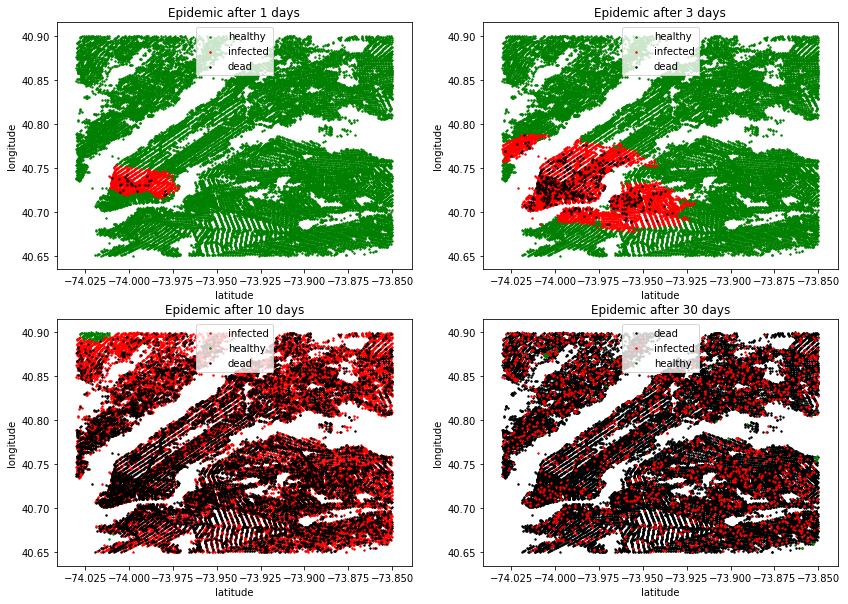

In [37]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
visualize_epidemics(sir, 23654, 1, [0,1,2])
plt.subplot(2,2,2)
visualize_epidemics(sir, 23654, 3, [0,1,2])
plt.subplot(2,2,3)
visualize_epidemics(sir, 23654, 10, [1,0,2])
plt.subplot(2,2,4)
visualize_epidemics(sir, 23654, 30, [2,1,0])

#### Exercise 2.11: Strategy 2

In [69]:
H_1000 = G.copy()
H_10000 = G.copy()

edges = list(G.edges)
np.random.shuffle(edges)
rem_edges_1000 = edges[:1000]
np.random.shuffle(edges)
rem_edges_10000 = edges[:10000]

for edge in rem_edges_1000:
    H_1000.remove_edge(*edge)
for edge in rem_edges_10000:
    H_10000.remove_edge(*edge)
    
sir_1000 = epidemics_helper.SimulationSIR(H_1000, beta=10.0, gamma=0.1, verbose=False)
sir_10000 = epidemics_helper.SimulationSIR(H_10000, beta=10.0, gamma=0.1, verbose=False)

In [73]:
def mean_time_to_reach_60_perc(sir2, sir3):
    normal_i_c = np.zeros(100)
    normal_r_c = np.zeros(100)
    leveraged_i_c = np.zeros(100)
    leveraged_r_c = np.zeros(100)
    leveraged2_i_c = np.zeros(100)
    leveraged2_r_c = np.zeros(100)
    for i in range(100):
        src = np.random.choice(range(H.number_of_nodes()))
        sir.launch_epidemic(source=src, max_time=100)
        sir2.launch_epidemic(source=src, max_time=100)
        sir3.launch_epidemic(source=src, max_time=100)
        p1, p2, p3, = status_percentages(sir)
        normal_i_c[i] = len(p2[p2 < sir.n_nodes*.6])
        normal_r_c[i] = len(p3[p3 < sir.n_nodes*.6])
        p1, p2, p3 = status_percentages(sir2)
        leveraged_i_c[i] = len(p2[p2 < sir.n_nodes*.6])
        leveraged_r_c[i] = len(p3[p3 < sir.n_nodes*.6])
        p1, p2, p3 = status_percentages(sir3)
        leveraged2_i_c[i] = len(p2[p2 < sir.n_nodes*.6])
        leveraged2_r_c[i] = len(p3[p3 < sir.n_nodes*.6])
        
    return (np.mean(normal_i_c), np.mean(leveraged_i_c), np.mean(normal_r_c), np.mean(leveraged_r_c)), (np.mean(normal_i_c), np.mean(leveraged2_i_c), np.mean(normal_r_c), np.mean(leveraged2_r_c))

In [74]:
diff_1000, diff_10000 = mean_time_to_reach_60_perc(sir_1000, sir_10000)
print('Mean time to reach 60% of infected: normal:', diff_1000[0], 'after removing 1000 edges', diff_1000[1])
print('Mean time to reach 60% of dead: normal:', diff_1000[2], 'after removing 1000 edges', diff_1000[3])
print('Mean time to reach 60% of infected: normal:', diff_10000[0], 'after removing 10000 edges', diff_10000[1])
print('Mean time to reach 60% of dead: normal:', diff_10000[2], 'after removing 10000 edges', diff_10000[3])

Mean time to reach 60% of infected: normal: 9.05 after removing 1000 edges 8.61
Mean time to reach 60% of dead: normal: 17.62 after removing 1000 edges 17.2
Mean time to reach 60% of infected: normal: 9.05 after removing 10000 edges 25.54
Mean time to reach 60% of dead: normal: 17.62 after removing 10000 edges 34.48


Epidemic stopped after 1.00 days | 1.00 days elapsed | 97.4% susceptible, 2.5% infected, 0.1% recovered
Epidemic stopped after 3.00 days | 3.00 days elapsed | 87.5% susceptible, 11.1% infected, 1.4% recovered
Epidemic stopped after 10.00 days | 10.00 days elapsed | 1.4% susceptible, 62.6% infected, 36.1% recovered
Epidemic stopped after 30.00 days | 30.00 days elapsed | 0.4% susceptible, 9.1% infected, 90.5% recovered


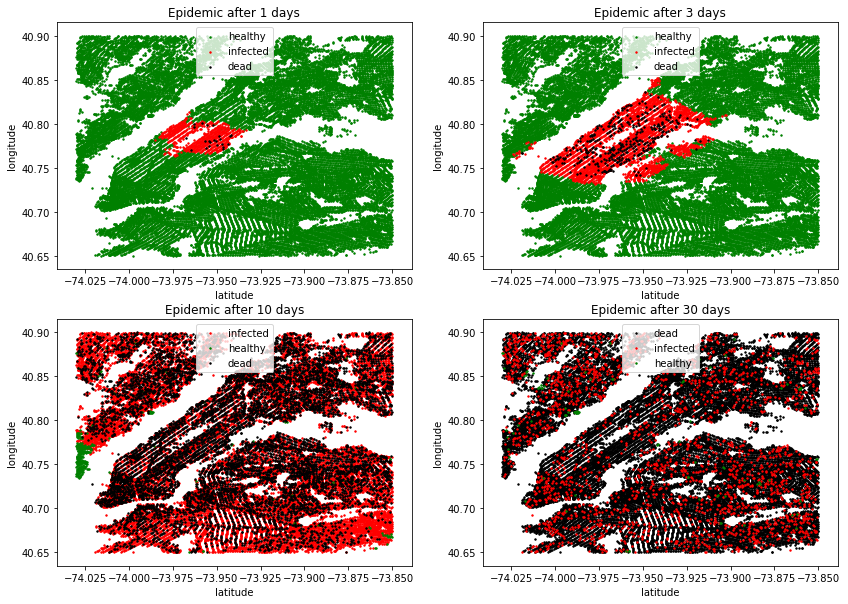

In [47]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
visualize_epidemics(sir2, start, 1, [0,1,2])
plt.subplot(2,2,2)
visualize_epidemics(sir2, start, 3, [0,1,2])
plt.subplot(2,2,3)
visualize_epidemics(sir2, start, 10, [1,0,2])
plt.subplot(2,2,4)
visualize_epidemics(sir2, start, 30, [2,1,0])